#### Lesson 15 Chapter 6 ツール呼び出しエージェントの構築

Lesson 15 Chapter 6.1 準備

In [1]:
import os
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI

# 環境変数の読み込み
load_dotenv("../.env")
os.environ['OPENAI_API_KEY'] = os.environ['API_KEY']

# モデル名
MODEL_NAME = "gpt-4o-mini"

Lesson 15 Chapter 6.2 検索ツールの定義

In [2]:
# 検索ツールの定義
from langchain_community.tools.tavily_search import TavilySearchResults

tool = TavilySearchResults(max_results=2)
tools = [tool]

In [4]:
tool.invoke("Langgraphのノードとは？")

[{'url': 'https://blog.elcamy.com/posts/136913a3',
  'content': 'Copy \n\n```\nfrom langgraph.graph import MessagesState\n\nclass State(MessagesState):\n    documents: list[str]\n```\n\n##### Nodes\n\n  \n\nLangGraphにおいて、Nodesはエージェントの特定の作業を実行するPython関数（同期または非同期）です。以下の図の赤枠で囲まれた部分がノードを表します。\n\nImage 5: image block\n\nNodesの最初の引数はStateで、オプションの2番目の引数には設定パラメータを含む辞書型変数が渡されます。\n\n具体的にはノードは、以下のようにしてグラフに追加されます。\n\n Copy \n\n```\nfrom langchain_core.runnables import RunnableConfig\nfrom langgraph.graph import StateGraph\n\nbuilder = StateGraph(dict) [...] このように、LangGraphではノードとエッジを組み合わせて、複雑なエージェントのワークフローを構築できます。各ノードは特定のタスクを実行し、エッジが次に実行するノードを決定します。\n\n##### Edges\n\n  \n\nEdgesは、エージェントの動作を制御し、異なるノード間の通信を定義する重要な要素です。エッジは以下の図の矢印にあたります。\n\nImage 6: image block\n\nEdgesの種類は以下の通りです。\n\n   通常のエッジ：一つのノードから次のノードへ直接移動します。 \n   条件付きエッジ：次にどのノードに移動するかを決定するための関数を使用します。 \n   エントリーポイント：ユーザー入力が到着したときに最初に呼び出されるノードです。 \n   条件付きエントリーポイント：ユーザー入力が到着したときに最初にどのノードを呼び出すかを決定するための関数を使用します。 \n\nノードは複数の出力エッジを持つことができ\n\n#####

Lesson 15 Chapter 6.3 ステートグラフの作成とチャットボットノードの追加

In [5]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages

# Stateクラスの定義
class State(TypedDict):
    messages: Annotated[list, add_messages]

# グラフのインスタンスを作成
graph_builder = StateGraph(State)

# 言語モデルの定義
llm = ChatOpenAI(model_name=MODEL_NAME)

# 変更点：ツール定義の紐づけ
llm_with_tools = llm.bind_tools(tools)

# チャットボットノードの作成
def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

# グラフにチャットボットノードを追加
graph_builder.add_node("chatbot", chatbot)

Lesson 15 Chapter 6.4 ツールノードの追加

In [7]:
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.checkpoint.memory import MemorySaver

# ツールノードの作成
tool_node = ToolNode(tools)

# グラフにツールノードを追加
graph_builder.add_node("tools", tool_node)

# 条件付エッジの作成
graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition, # ツール呼出と判断したらツールノードを呼ぶ 
)

# ツールが呼び出されるたびに、チェットボットに戻って次のステップを決定
# ツールからチャットボットへの戻りエッジを作成
graph_builder.add_edge("tools", "chatbot")

# 開始ノードの指定
graph_builder.set_entry_point("chatbot")

# 記憶を持つ実行可能なステートグラフの作成
memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

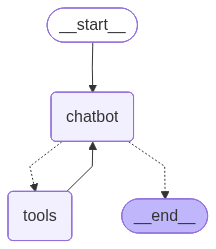

In [9]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

Lesson 15 Chapter 6.5 動作確認

In [10]:
# グラフの実行と結果の表示
def stream_graph_updates(user_input: str):
    events = graph.stream(
        {"messages": [("user", user_input)]},
        {"configurable": {"thread_id": "1"}},
        stream_mode="values")
    # 結果をストリーミングで得る
    for event in events:
        print(event["messages"][-1].content, flush=True)

# チャットボットのグループ
while True:
    user_input = input("質問:")
    if user_input.strip()=="":
        print("ありがとうございました！")
        break
    stream_graph_updates(user_input)

こんにちは！
こんにちは！今日はどのようにお手伝いできますか？
1足す2は？
1足す2は3です。何か他に知りたいことはありますか？
1メートル以上の魚は？

[{"url": "https://tsurihack.com/8448", "content": "どの魚も、陸っぱりで狙えて最大全長が1mを超えるものばかり！\n\nお住まいの地域にこれからリストアップする魚が生息していたら、狙ってみてはいかがでしょうか。\n\n鯉｜もっとも手軽で簡単な大物\n\n難易度：★☆☆｜平均70cm、1m超えれば超絶レア\n魚釣り初心者の方にオススメしたいのは食パンを使ったコイ釣りです！\n\n安・近・短で手軽に釣ることができ、ボウズ（釣果ゼロ）で終わってしまうリスクも少ないのがパンコイゲームの魅力ですね。\n\n▼食パンを使ったコイの釣り方はこちら！\n針と餌だけのカンタン仕掛けで巨大魚が釣れる！？“パン鯉”に子供と挑戦してみました2023/04/27釣り好き！まっちゃん\n\n針と餌だけのカンタン仕掛けで巨大魚が釣れる！？“パン鯉”に子供と挑戦してみました\n\n2023/04/27釣り好き！まっちゃん\n\n1mを超えるコイは超絶レアですよ！\n\n身近な川魚のコイといえども最大サイズは1ｍを優に超え、コイを専門に狙う釣り人にとってメーター超えの巨鯉は一生に1匹でも良いから釣ってみたい憧れのサイズです。 [...] 最大で1mに迫るような大物を釣り狙う場合、例え身近な魚であっても釣り具の強度や仕掛け、ルアーの種類などをしっかり選ぶ必要があります。\n\n『この魚を釣ってみたい！』という確固たる目標を持って挑戦していく過程が大物釣り最大の醍醐味であり、準備や試行錯誤の期間が長い程、目標を手にした瞬間、つまり大物を釣り上げた瞬間の感動と達成感はなんとも言葉に表すことができないものになってきます。\n\n全身が震えたり、感情を抑えられず雄たけびやガッツポーズが出ちゃったりする……そんな体験を大人になっても味わえる。それが魚釣りの良い所だと僕は思っています。\n\n大物を釣り上げるまでの3ステップをお伝えします\n\nどんな大物を釣りたいか決めましょう\n\nまずは、自分の目標とする魚を設定しましょう。魚種でも良いですし、この魚の何センチ以上！　とかでも素敵な目標だと思います。\n